# TFLite Conversion
In this notebook all models are converted to TFLite. A comparison between the original models and the TFLite version is being done in the end.

# 00 Imports

In [12]:
import os
import numpy as np
import pandas as pd
import pickle
import datetime

from dataloader import dataloader
from predicter import Predicter, Predicter_norm
import tensorflow as tf

# Matplot Setup
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (50,10)
plt.rcParams['figure.max_open_warning'] = 40
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth']= 1

%autoreload 2

UsageError: Line magic function `%autoreload` not found.


# 01 Load Model paths and one state dict

In [21]:
folder = 'models_short'
models_files = sorted(os.listdir(folder))
if models_files[-1] == 'tflite_temp':
    models_files = models_files[:-1]
print(f'Available models:')
for num, m in enumerate(models_files):
    print(f'\t{num}: {m}')


p_pickle = rf'{folder}/{models_files[-3]}/{models_files[-3]}_dict.pickle'
with open(p_pickle, 'rb') as f:
    sd = pickle.load(f)

Available models:
	0: 20220129-172313_lmt_2
	1: 20220129-172814_lmt_2
	2: 20220129-174334_lmt_2
	3: 20220129-182242_lmt_2
	4: 20220129-183645_lmt_2
	5: 20220129-193543_lmt_2
	6: 20220129-214702_lmt_2_long


# 02 Convert to TFLite
Instructions taken from here:
https://www.tensorflow.org/lite/convert/rnn

This colab notebook was essential for understanding how to do a successful conversion:
https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/examples/experimental_new_converter/Keras_LSTM_fusion_Codelab.ipynb#scrollTo=5pGyWlkJDpMQ



In [14]:
def tf_converter(name, model_dir = f'{folder}/', sd = sd, save = True):
    # Load keras model
    keras_name = f'{model_dir}/{name}/{name}.h5'
    temp_dir = f'{model_dir}/{name}/tflite_temp/'
    
    if not os.path.exists(temp_dir):
        os.mkdir(temp_dir)

    model = tf.keras.models.load_model(keras_name)

    # Create lambda function for calling the model (could also be done with tf function)
    run_model = tf.function(lambda x: model(x))
    
    # This is important, let's fix the input size.
    BATCH_SIZE = 1
    STEPS = sd['win_len']
    INPUT_SIZE = len(sd['f_params'])
    concrete_func = run_model.get_concrete_function(
        tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model.inputs[0].dtype))

    # model directory.
    temp_dir = model_dir + 'tflite_temp/'
    model.save(temp_dir, save_format="tf", signatures=concrete_func)

    converter = tf.lite.TFLiteConverter.from_saved_model(temp_dir)
    tflite_model = converter.convert()

    if save:
        tflite_name = f'{model_dir}/{name}/{name}.tflite'
        with open(tflite_name, 'wb') as f:
            f.write(tflite_model)
    
    return tflite_model, model

for m in [models_files[-1]]:
    tf_converter(m, save=True)

INFO:tensorflow:Assets written to: models_short/tflite_temp/assets


INFO:tensorflow:Assets written to: models_short/tflite_temp/assets
2022-01-29 23:09:34.373787: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2022-01-29 23:09:34.373813: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2022-01-29 23:09:34.373818: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:372] Ignored change_concat_input_ranges.
2022-01-29 23:09:34.374017: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: models_short/tflite_temp/
2022-01-29 23:09:34.438821: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2022-01-29 23:09:34.438885: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: models_short/tflite_temp/
2022-01-29 23:09:34.683584: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2022-01-29 23:09:35.148998: I tensorflow/cc/saved_model/loade

Estimated count of arithmetic ops: 0.316 M  ops, equivalently 0.158 M  MACs


# 03 Load Test Data

In [22]:
print(os.listdir(sd['data_path']))
data = dataloader(sd['data_path'], win_len = sd['win_len'], target_len = sd['target_len'], stride = sd['stride'], feature_params= sd['f_params'], 
                  target_params= sd['t_params'], test_split=0.08, val_split=0.08, seed=sd['seed'], downsample_rate=sd['downsample_rate'], stack=True)

X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']
sample_rate = data['sample_rate']

['2021-11-26-20-14-48_wobble_interpolated_120Hz.pickle', '2021-11-26-20-01-52_wobble_interpolated_120Hz.pickle', '2022-01-20-15-38-51_wobble_interpolated_120Hz.pickle', '2022-01-13-18-02-22_wobble_interpolated_120Hz.pickle', '2021-11-26-20-05-14_wobble_interpolated_120Hz.pickle', '2022-01-20-15-23-37_wobble_interpolated_120Hz.pickle', '2022-01-13-17-48-10_wobble_interpolated_120Hz.pickle', '2022-01-13-17-18-38_wobble_interpolated_120Hz.pickle', '2022-01-13-17-34-38_wobble_interpolated_120Hz.pickle']
2021-11-26-20-14-48_wobble_interpolated_120Hz.pickle
Downsampling Dictionary to 10Hz
Cutoff frequency: 5.0
Converted Signals: ['orientation.x', 'orientation.y', 'orientation.z', 'orientation.w', 'angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z', 'linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z', 'position_0', 'position_1', 'position_0_status', 'position_1_status'].
	Before: Duration: 400.775s. Avg Sample Rate: 120.000/s. Number of samples: 48093.
	Afte

# 04 Compare TFLite models with their original counterpart
Apparently the inference results vary on the used tflite_runtime installation. The most accurate way would be to build tflite_runtime  2.7.0 on the nanopi. This needs a lot of knowledge and fine tuning, which is why eventually intalled the tflite_runtime version 2.5.0.post1 which is available 

In [16]:
from predicter import Predicter, Predicter_norm

In [19]:
keras_Ps = []
tflite_Ps = []

for m in [models_files[-1]]:
    print(m)
    keras_path = f'{folder}/{m}/{m}.h5'
    tflite_path = f'{folder}/{m}/{m}.tflite'
    keras_Ps.append(Predicter_norm(keras_path))
    tflite_Ps.append(Predicter(tflite_path))

20220129-214702_lmt_2_long


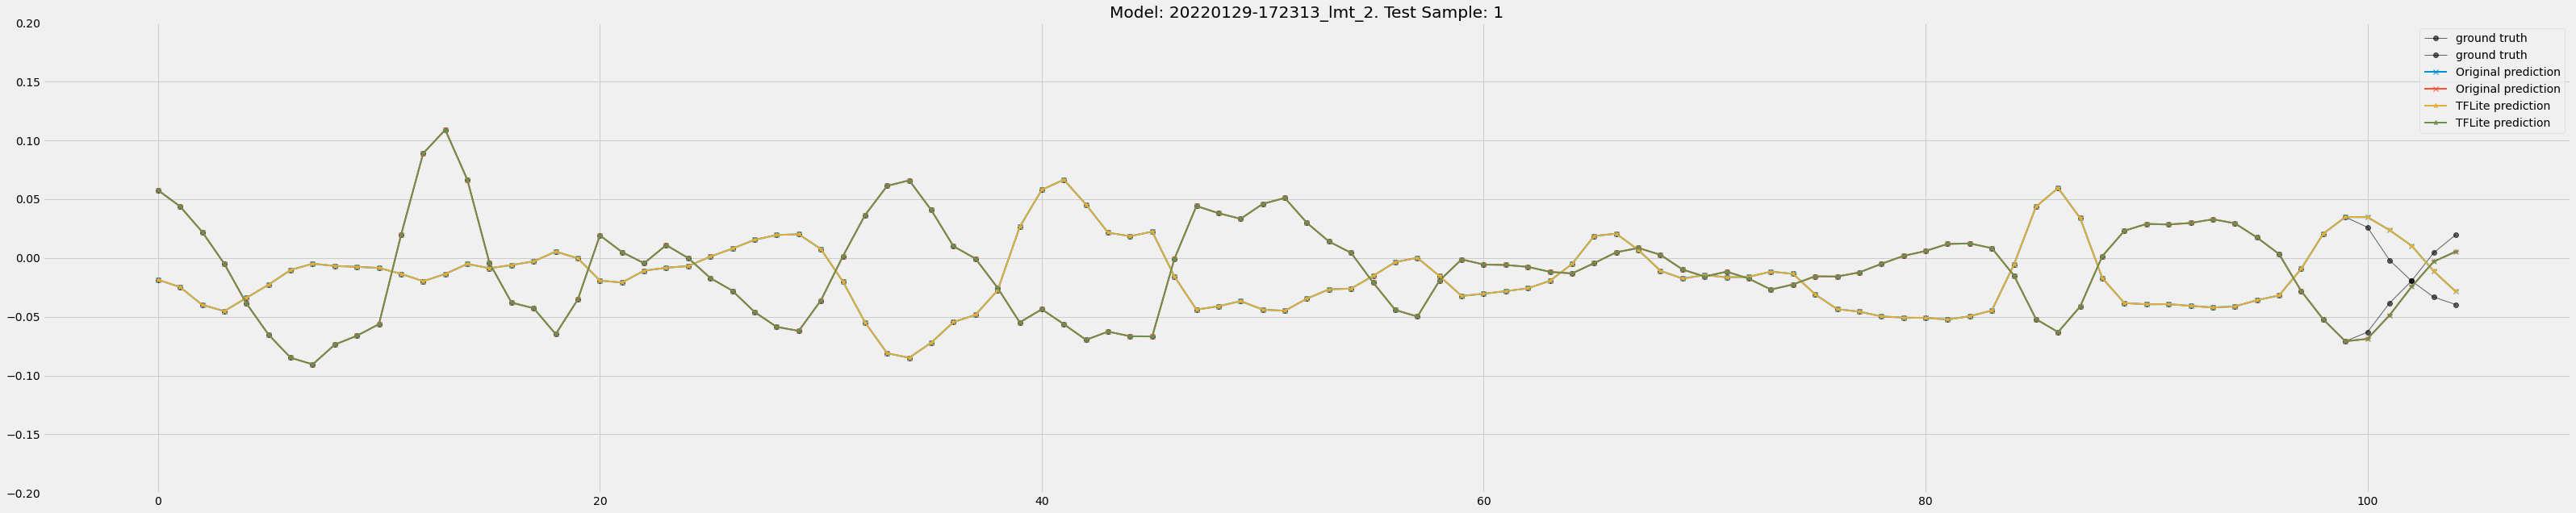

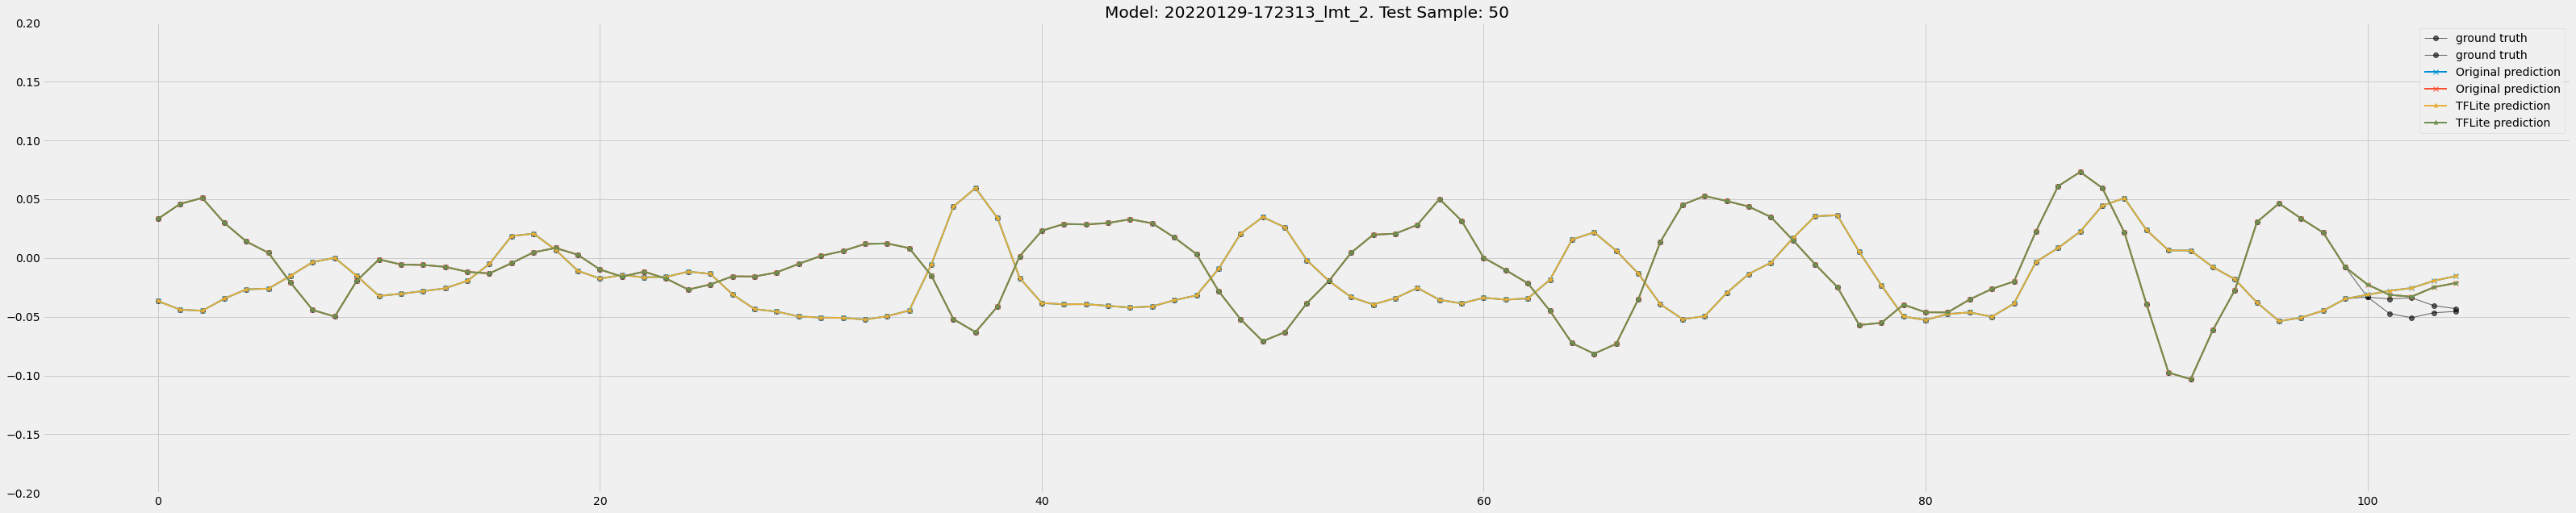

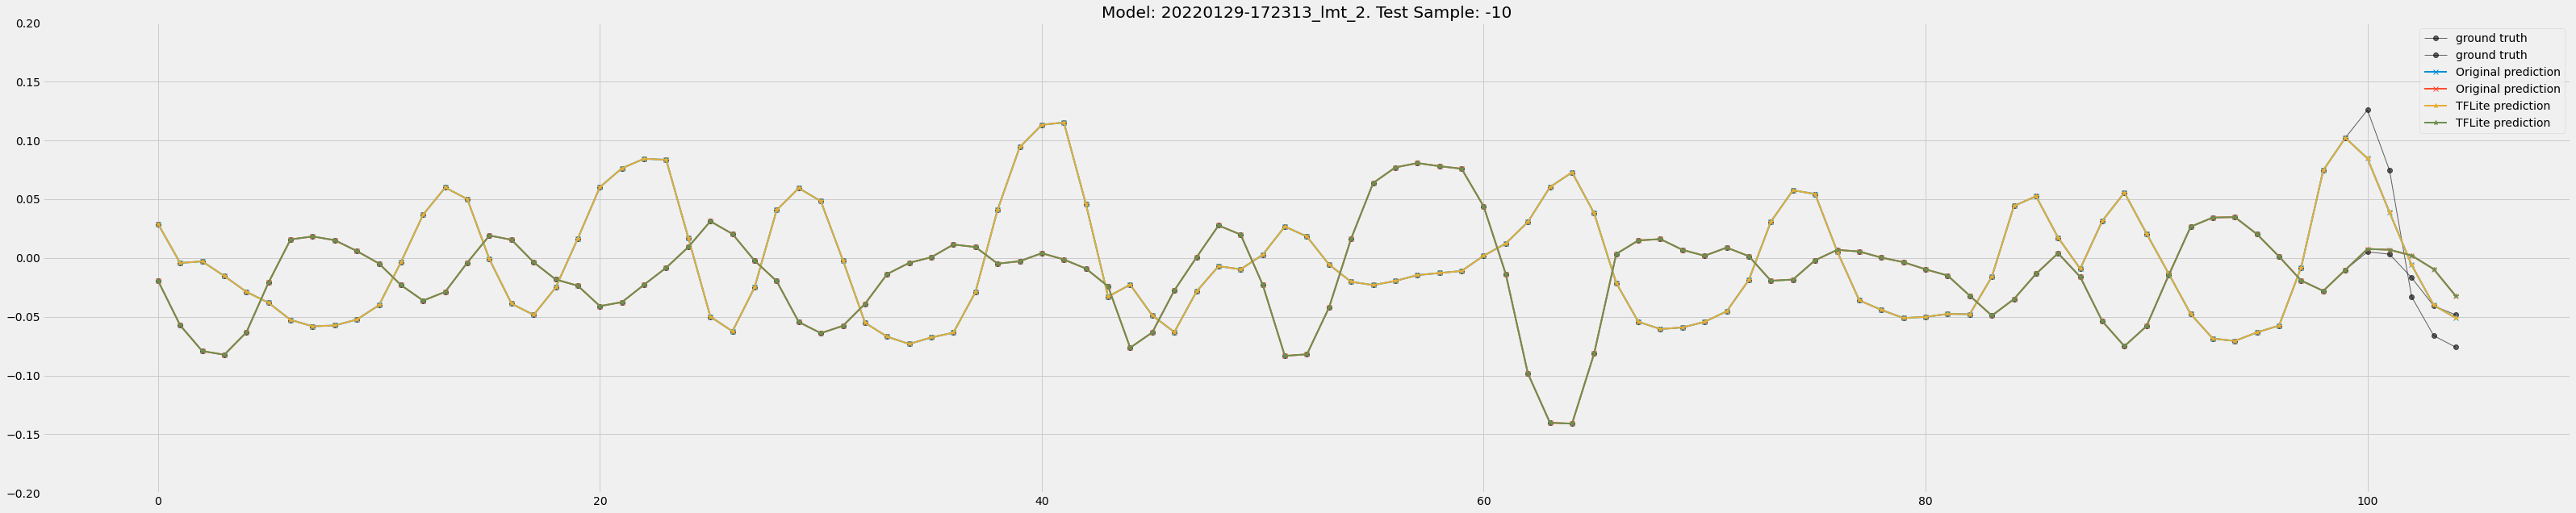

In [20]:
samples = [1,50, -10]
for k_p, tf_p, m in zip(keras_Ps, tflite_Ps, models_files):
    for s in samples:
        pred_k = k_p.predict(X_test[s])
        pred_tf = tf_p.predict(X_test[s])

        plt.figure()
        plt.plot(np.vstack([X_test[s], y_test[s]]), label = 'ground truth', color = 'black', marker = 'o', alpha=.6)
        plt.plot(np.vstack([X_test[s], pred_k]), label = 'Original prediction', marker='x', linewidth=2)
        plt.plot(np.vstack([X_test[s], pred_tf]), label = 'TFLite prediction', marker = '*', linewidth = 2)
        plt.title(f'Model: {m}. Test Sample: {s}')
        plt.legend()
        plt.ylim([-.2,.2])

#### Conclusion
The predictions made by the tflite model hardly vary from the predictions made by the keras model. The TFLite models can therefore safely be used.